In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

import pickle
import json
import sys
import numpy.random as random
sys.path.append("../../../")

import time 
from src.online_prediction import ContextFreeOnlinePredictor
from src.context_free.models import createModel

In [2]:
rawDatasetFolder = "../../../data/raw"
configPath = "../../config/combined_flows_forward_20.json"
modelFolder = "../../../data/models/context_free"
trafficDataFolder = "../../../data/processed/dpdr"
verbose = True

In [3]:
config = json.load(open(configPath))
name = config.get("NAME")
len_window = config.get("LEN_WINDOW")
dim_data =  len(config.get("CONTEXT_IDXS"))

In [4]:
csv_data = pd.read_csv(f"{trafficDataFolder}/{name}.csv")

with open(f"{modelFolder}/{name}_modelConfig.pkl", "rb") as f:
    modelConfig = pickle.load(f)
with open(f"{modelFolder}/{name}_metaConfig.pkl", "rb") as f:
    metaConfig = pickle.load(f)

metaConfig.display()
model, device = createModel(modelConfig)
model.load_checkpoint(f"{modelFolder}/{name}.pth")

MetaConfig:
  dim_data: 12
  len_window: 20
  len_source: 10
  len_target: 1
  train_ratio: 0.6
  data_augment: True
  Ts: 0.01


In [11]:
onlinePredictor = ContextFreeOnlinePredictor(model, metaConfig)

traffic_recieved_list = []
traffic_generated_list = []
traffic_predicted_list = []

last_time = time.time()
last_window_time = time.time()
count = 0
transmit_count = 0
N_count = 5000
while True:
    if time.time() - last_time > metaConfig.Ts:
        # ==================== transmiter ====================
        last_time = time.time()
        transmission = csv_data.iloc[count, 1]
        data_point = csv_data.iloc[count, 2:].values
        count += 1            
        if count >= N_count:
            break
        # ==================== receiver ====================
        # Invoked upon receiving a new data point
        if int(transmission) == 1:
            onlinePredictor.receive_signal()
            transmit_count += 1

        # Invoked every window_length * Ts seconds
        if time.time() - last_window_time > metaConfig.len_window * metaConfig.Ts:
            last_window_time = time.time()
            traffic_generated_list.append(transmit_count)
            transmit_count = 0
            if onlinePredictor.is_ready():
                traffic_predicted, traffic_recieved = onlinePredictor.predict()
                traffic_predicted = np.round(traffic_predicted,0).astype(int)
                traffic_predicted_list.append(traffic_predicted)
                traffic_recieved_list.append(traffic_recieved)

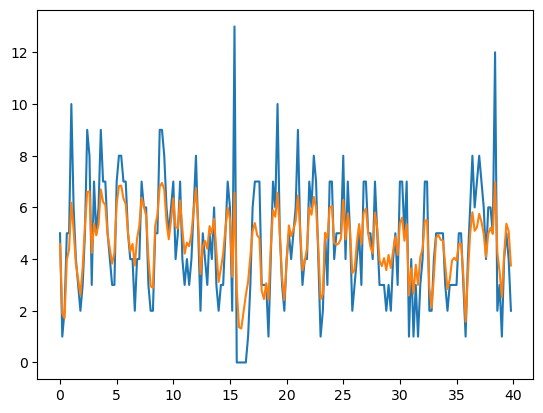

In [10]:
N_display = min(200, len(traffic_recieved_list))
timestamp = np.arange(len(traffic_recieved_list)) * metaConfig.Ts * metaConfig.len_window
plt.plot(timestamp[:N_display], traffic_recieved_list[:N_display])
plt.plot(timestamp[:N_display], traffic_predicted_list[:N_display])
plt.show()